# Load Station Status Stream Files

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime
import math

import seaborn as sns
sns.set()

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
font = {'size'   : 50}
matplotlib.rc('font', **font)

LABEL_FONT_SIZE = 15
TITLE_FONT_SIZE = 25

## Import Data

In [4]:
def load_status_data():

    print('Loading Status Data...')
    file_path_slug = '../streamed_data/*/*station_status*.csv'

    # glob all files
    file_list = glob(file_path_slug)

    df = pd.DataFrame()
    chunks = []
    counter = 0
    
    print('Started Import (%s files to load)...' % len(file_list))

    # load data from each file
    for file in file_list:
        try:

            # import file in chunks
            chunk = pd.read_csv(file)

            # add program id to chunk
            chunk['program_id'] = str(file).split('/')[2]

            # append chunk to chunks list
            chunks.append(chunk)
            
            counter += 1
            if counter == 1 or counter % math.ceil(len(file_list)/10) == 0 or counter == len(file_list):
                print('\tFinished file! (%d of %d)' % (counter, len(file_list)))        
        except:
            print(file)

    df = pd.concat(chunks)
    print('Data Loaded Successfully!\n')
    return df
    
def clean_data(df):
    program_list = sorted(pd.unique(df.program_id))
    print('Started cleaning (%s programs to clean)...' % len(program_list))
    df.rename(columns={'last_reported' : 'time',
                                     'eightd_has_available_keys' : 'has_available_keys',
                                     'is_installed' : 'is_installed',
                                     'is_renting' : 'is_renting',
                                     'is_returning' : 'is_returning',
                                     'num_bikes_available' : 'bikes_available',
                                     'num_bikes_disabled' : 'bikes_disabled',
                                     'num_docks_available' : 'docks_available',
                                     'num_docks_disabled' : 'docks_disabled',
                                     'station_id' : 'station_id'}, inplace=True)

    drop_cols = ['eightd_active_station_services', 'has_available_keys', 'is_installed', 'is_renting', 'is_returning', 'bikes_disabled', 'docks_disabled', 'renting', 'returning', 'installed']

    for c in drop_cols:
        try:
            df.drop(c, axis=1, inplace=True)
        except:
            pass

    # convert time to datetime, and prune entries pre 2000, some epoch dates are being reported
    df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%d %H:%M:%S")
    change_date = pd.Timestamp('2000-01-01 00:00')
    df = df[df.time >= change_date].copy()

    df.sort_values(['program_id', 'station_id', 'time'], inplace=True)
    
    A = len(df)
    df.drop_duplicates(subset=['time', 'program_id', 'station_id'], inplace=True)
    B = len(df)
    print('\t\tDropped %s duplicates!' % (A-B))
    
    # by program and station ,append dock change and bike change
    cleaned_df = pd.DataFrame()
    cleaned_list = []
    counter = 1
    for pid in program_list:

        df_temp_program = df[df.program_id == pid].copy()

        # for each dock
        print('%s\t%s - %s Stations to Clean...' % (str(counter).rjust(3), pid.ljust(25), str(len(pd.unique(df_temp_program.station_id))).rjust(4)))
        for sid in pd.unique(df_temp_program.station_id):
            df_temp_station = df_temp_program[df_temp_program.station_id == sid].copy()
            
            # drop duplicates
            A = len(df_temp_station)
            df_temp_station.drop_duplicates(subset='time', inplace=True)
            B = len(df_temp_station)
            if A != B:
                print('\t%s\tDropped %s duplicates!' % (sid, (A-B)))
            
            df_temp_station.sort_values(['time'], inplace=True)
            
            df_temp_station['trips_ending'] = df_temp_station['bikes_available'].diff().apply(lambda x: x if x > 0 else 0)
            df_temp_station['trips_starting'] = df_temp_station['docks_available'].diff().apply(lambda x: x if x > 0 else 0)
            df_temp_station['net_traffic'] = df_temp_station['trips_starting'] - df_temp_station['trips_ending']

            cleaned_list.append(df_temp_station)
            
        counter += 1

    print('Merging DataFrame...')
    cleaned_df = pd.concat(cleaned_list)
    cleaned_df.reset_index(inplace=True, drop=True)

    print('Cleaning Complete!')

    return cleaned_df


In [5]:
status_import = load_status_data()

Loading Status Data...
Started Import (54498 files to load)...
	Finished file! (1 of 54498)
	Finished file! (5450 of 54498)
	Finished file! (10900 of 54498)
	Finished file! (16350 of 54498)
	Finished file! (21800 of 54498)
	Finished file! (27250 of 54498)
	Finished file! (32700 of 54498)
	Finished file! (38150 of 54498)
	Finished file! (43600 of 54498)
	Finished file! (49050 of 54498)
	Finished file! (54498 of 54498)
Data Loaded Successfully!



In [6]:
status_data = clean_data(status_import)

Started cleaning (70 programs to clean)...
		Dropped 6374013 duplicates!
  1	aru                       -    8 Stations to Clean...
  2	asp                       -   21 Stations to Clean...
  3	ba                        -  254 Stations to Clean...
  4	bcyclearborbike           -   13 Stations to Clean...
  5	bcycleaustin              -   54 Stations to Clean...
  6	bcycleaventura            -    5 Stations to Clean...
  7	bcyclebattlecreek         -    4 Stations to Clean...
  8	bcycleboulder             -   43 Stations to Clean...
  9	bcyclebroward             -   24 Stations to Clean...
 10	bcyclebublr               -   76 Stations to Clean...
 11	bcyclecatbike             -    2 Stations to Clean...
 12	bcyclecharlotte           -   25 Stations to Clean...
 13	bcyclecincyredbike        -   56 Stations to Clean...
 14	bcycleclarksville         -    5 Stations to Clean...
 15	bcycleclemson             -    5 Stations to Clean...
 16	bcyclecolumbiacounty      -    1 Stations to Clean...

In [7]:
status_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14265202 entries, 0 to 14265201
Data columns (total 8 columns):
time               datetime64[ns]
bikes_available    int64
docks_available    int64
program_id         object
station_id         object
trips_ending       float64
trips_starting     float64
net_traffic        float64
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 870.7+ MB


In [8]:
status_data.head(5)

,time,bikes_available,docks_available,program_id,station_id,trips_ending,trips_starting,net_traffic
0,2017-11-15 21:28:17,8,18,aru,1,0.0,0.0,0.0
1,2017-11-15 21:32:42,8,18,aru,1,0.0,0.0,0.0
2,2017-11-15 21:41:26,8,18,aru,1,0.0,0.0,0.0
3,2017-11-15 21:45:52,8,18,aru,1,0.0,0.0,0.0
4,2017-11-15 21:50:21,8,18,aru,1,0.0,0.0,0.0


In [9]:
def show_station(df, id, x_label = '', y_label = '', title_suffix='', color='b', col='bikes_available'):
    t = df[df.station_id == id]
    t.set_index('time', inplace=True)
    ax = t[col].cumsum().plot(color=color, figsize=(24,3))
    if title_suffix != '':
        title = 'Station %s - %s' % (id, title_suffix)
    elif y_label != '':
        title = 'Station %s - %s' % (id, y_label)
    else:
        title = 'Station %s' % id
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
    ax.set_xlabel(x_label, size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel(y_label, size=LABEL_FONT_SIZE, weight='bold')
    plt.show()

In [10]:
def plot_hourly_usage(df, title='CoGo', color='r'):
    
    try:
        df.sort_values('time', inplace=True)
        x_ticks = sorted(pd.unique(df.time.dt.hour))
        df_data = df[df.bike_change != 0]
        df_data.reset_index(inplace=True, drop=True)
        df_status_change = df_data.groupby([df_data.time.dt.hour])['station_id'].count()

        plt.subplots(figsize=(24,3))
        ax = sns.barplot(x = df_status_change.index , y = df_status_change, color=color, alpha = 0.25, label=title)
        ax.set_title('Distribution of Trips by Hour', size=TITLE_FONT_SIZE, weight='bold')
        ax.set_xlabel('Start Hour', size=LABEL_FONT_SIZE, weight='bold')
        ax.set_ylabel('Total Trips', size=LABEL_FONT_SIZE, weight='bold')
        ax.set_xticks(x_ticks)
        plt.legend()
        plt.show()
    except:
        print('Unable to plot %s' % title)

In [11]:
def resample_status(df, interval='5T', verbose=False):
    if verbose:
        print('[%s] Resampling on interval' % datetime.datetime.now().time())
    
    resampled_list = []
    
    for pid in pd.unique(df.program_id):

            df_temp = df[df.program_id == pid].copy()
            
            df_temp.set_index(['station_id', 'time'], inplace=True)

            # resample on 5 minute interval mean
            df_temp = df_temp.groupby([pd.Grouper(level=0), pd.Grouper(freq=interval, level=-1)]).mean()
            df_temp.reset_index(inplace=True)
            
            df_temp['program_id'] = pid
         
            resampled_list.append(df_temp)

    resampled_df = pd.concat(resampled_list)
    resampled_df.reset_index(inplace=True, drop=True)
    
    if verbose:
        print('[%s] Complete' % datetime.datetime.now().time())
    return resampled_df

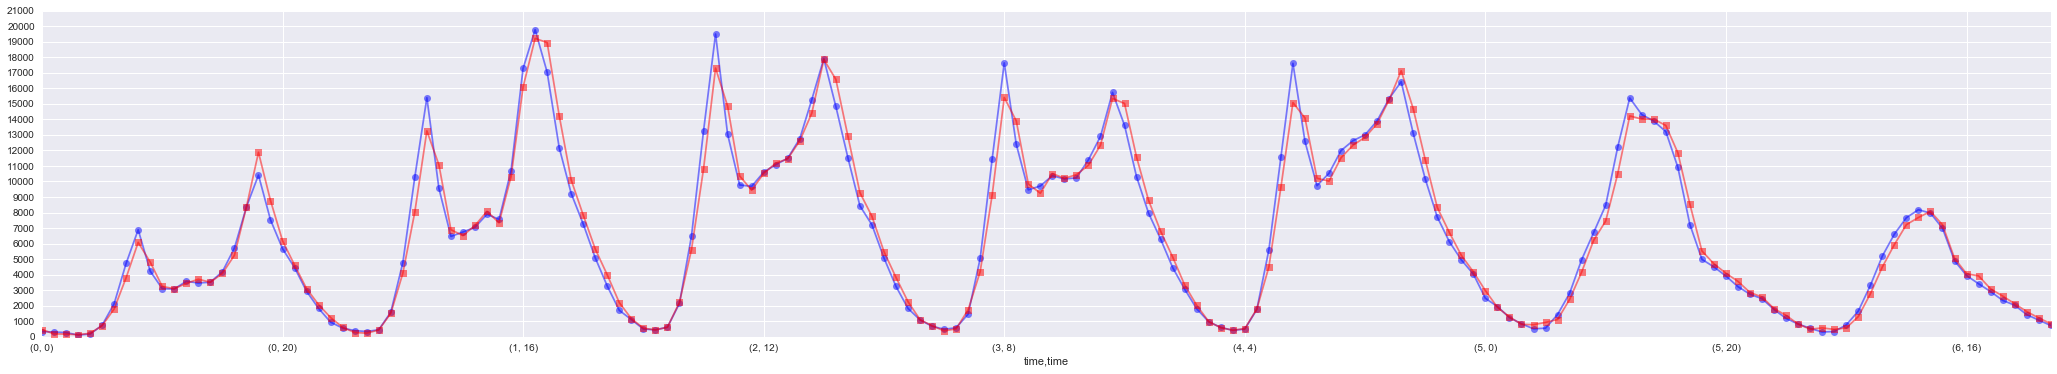

In [15]:
d0 = status_data.groupby([status_data.time.dt.dayofweek, status_data.time.dt.hour]).trips_starting.sum()
d1 = status_data.groupby([status_data.time.dt.dayofweek, status_data.time.dt.hour]).trips_ending.sum()

ax = d0.plot(figsize=(36,6), color='b', alpha=0.5, marker='o')
d1.plot(ax=ax, color='r', alpha=0.5, marker='s')


y_tick_interval = 1000
y_max = math.ceil(d0.max()/y_tick_interval)*y_tick_interval

if math.ceil(d1.max()/y_tick_interval)*y_tick_interval > y_max:
    y_max = math.ceil(d1.max()/y_tick_interval)*y_tick_interval

y_tick_max = int(y_max/y_tick_interval*1.1)

ax.set_ylim(0, y_max)
ax.set_yticks([y*y_tick_interval for y in range(0, y_tick_max)])

plt.show()

KeyboardInterrupt: 

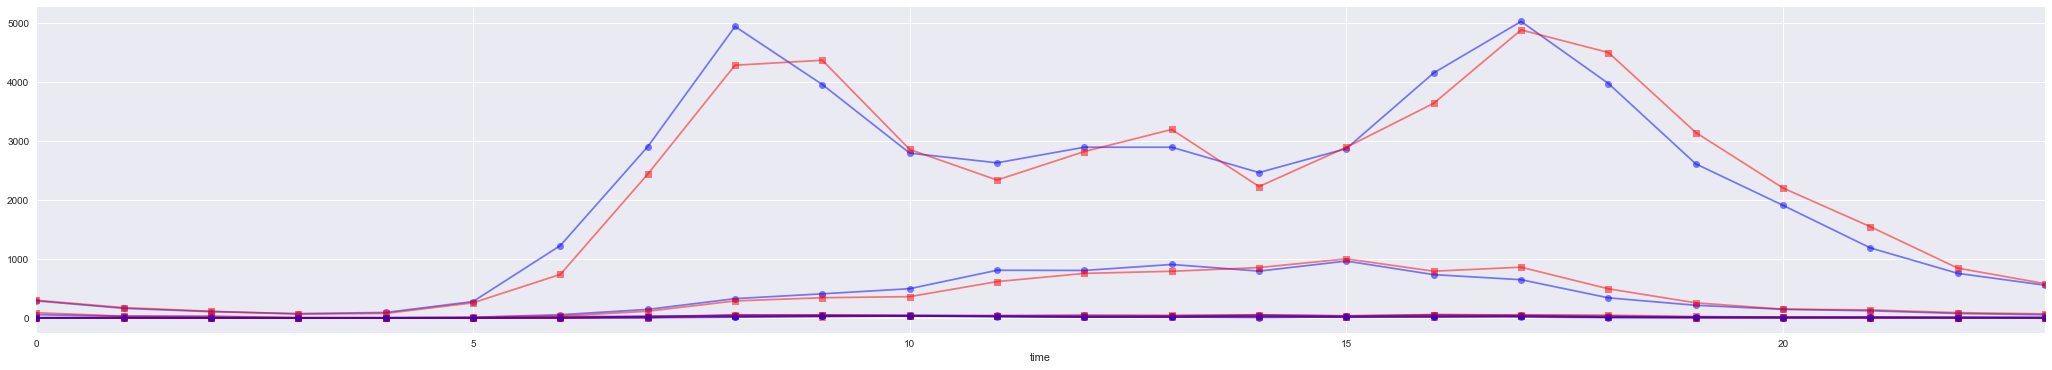

In [16]:
fig, ax = plt.subplots(figsize=(36,6))
y_max = 0
for pid in pd.unique(status_data.program_id):
    d0 = status_data[status_data.program_id == pid].groupby([status_data.time.dt.hour]).trips_starting.sum()
    d0.plot(color='b', alpha= 0.5, ax=ax, marker='o')
    
    if d0.max() > y_max:
        y_max = d0.max()
    
    d1 = status_data[status_data.program_id == pid].groupby([status_data.time.dt.hour]).trips_ending.sum()
    d1.plot(color='r', alpha= 0.5, ax=ax, marker='s')
        
    if d1.max() > y_max:
        y_max = d1.max()

y_tick_interval = 2500
y_max = math.ceil(y_max/y_tick_interval)*y_tick_interval
y_tick_max = int(y_max/y_tick_interval)+1
x_ticks = sorted(pd.unique(status_data.time.dt.hour))
ax.set_xticks(x_ticks)
ax.set_ylim(0, y_max)
ax.set_yticks([y*y_tick_interval for y in range(0, y_tick_max)])

plt.show()

In [17]:
print('Program ID\t\t\tTrips Starting\tTrips Ending\tNet')
for pid in pd.unique(status_data.program_id):
    S = status_data[status_data.program_id == pid].trips_starting.sum()
    E = status_data[status_data.program_id == pid].trips_ending.sum()
    print('%s\t%s\t\t%s\t\t%s' % (pid.ljust(25), str(S), str(E), S-E))

Program ID			Trips Starting	Trips Ending	Net
aru                      	337.0		355.0		-18.0
asp                      	388.0		386.0		2.0
ba                       	50717.0		50447.0		270.0
bcyclearborbike          	598.0		595.0		3.0
bcycleaustin             	8181.0		8177.0		4.0
bcycleaventura           	228.0		225.0		3.0
bcyclebattlecreek        	0.0		0.0		0.0
bcycleboulder            	3742.0		3760.0		-18.0
bcyclebroward            	2249.0		2245.0		4.0
bcyclebublr              	2231.0		2239.0		-8.0
bcyclecatbike            	63.0		61.0		2.0
bcyclecharlotte          	1974.0		1977.0		-3.0
bcyclecincyredbike       	2122.0		2114.0		8.0
bcycleclarksville        	230.0		227.0		3.0
bcycleclemson            	375.0		375.0		0.0
bcyclecolumbiacounty     	24.0		24.0		0.0
bcyclecolumbike          	61.0		60.0		1.0
bcycledallasfairpark     	2.0		2.0		0.0
bcycledenver             	12324.0		12319.0		5.0
bcycledesmoines          	251.0		249.0		2.0
bcycleelpaso             	684.0		677.0		7.0
bcyclefortworth  

In [ ]:
for pid in pd.unique(status_data.program_id):
    fig, ax = plt.subplots(figsize=(48,6))
    data = status_data[status_data.program_id == pid].groupby([status_data.time.dt.hour])
    data.trips_starting.sum().plot(kind ='line', color='b', alpha= 0.5, ax=ax, marker='o')
    data.trips_ending.sum().plot(kind ='line', color='r', alpha= 0.5, ax=ax, marker='s')
    title = 'Program - %s' % pid
    ax.set_title(title)
    x_ticks = range(0, 24)
    ax.set_xticks(x_ticks)
    plt.show()

Program ID			Trips Starting	Trips Ending	Net
ba                       	50717.0		50447.0		270.0


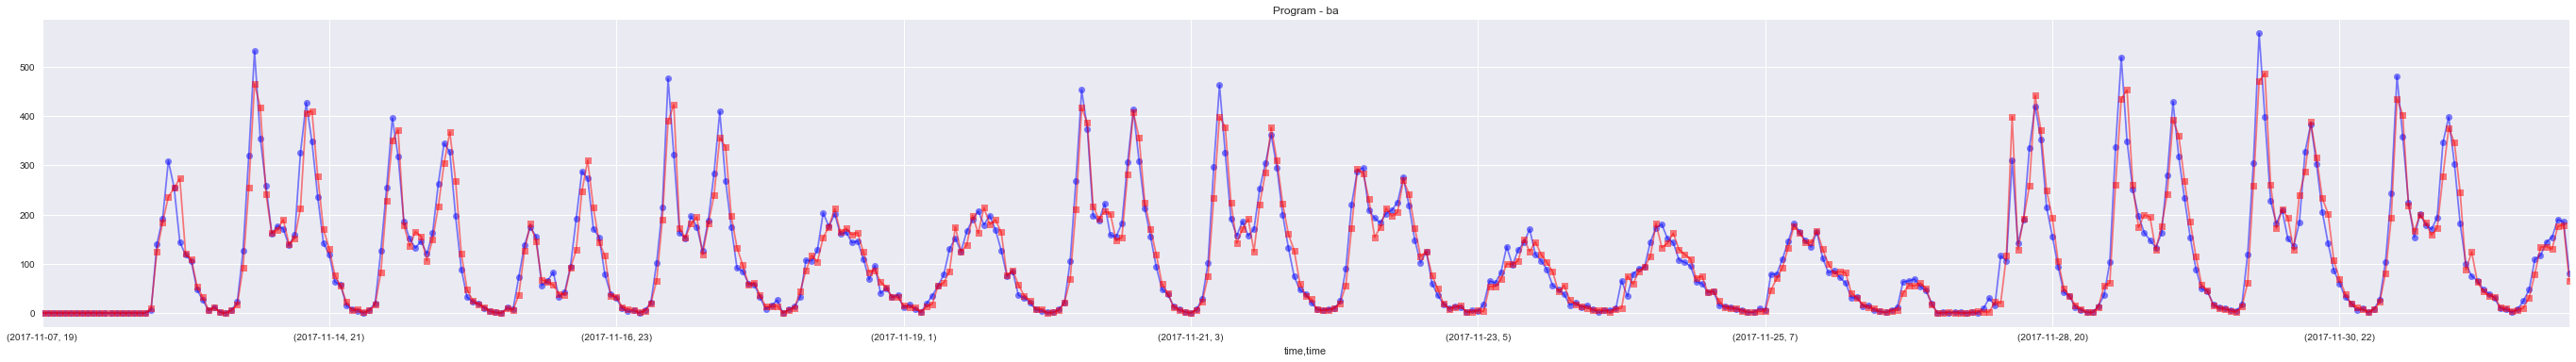

cabi                     	121246.0		121372.0		-126.0


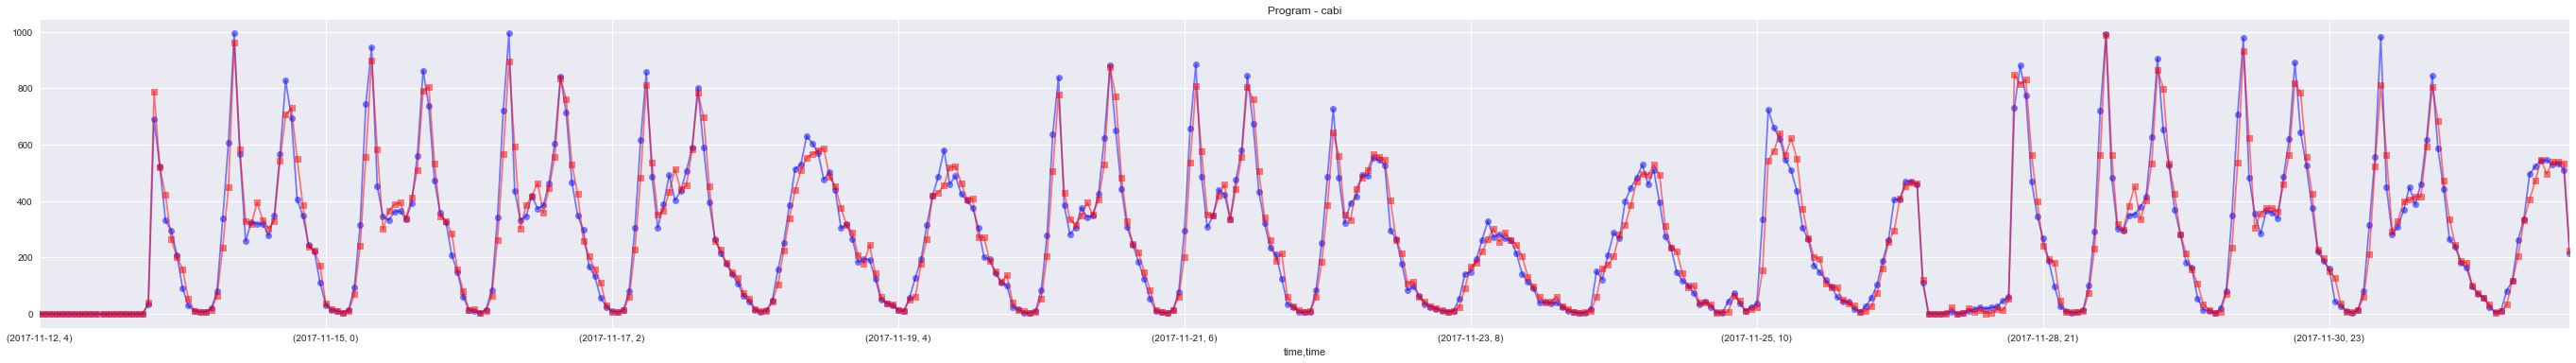

divvy                    	95272.0		94705.0		567.0


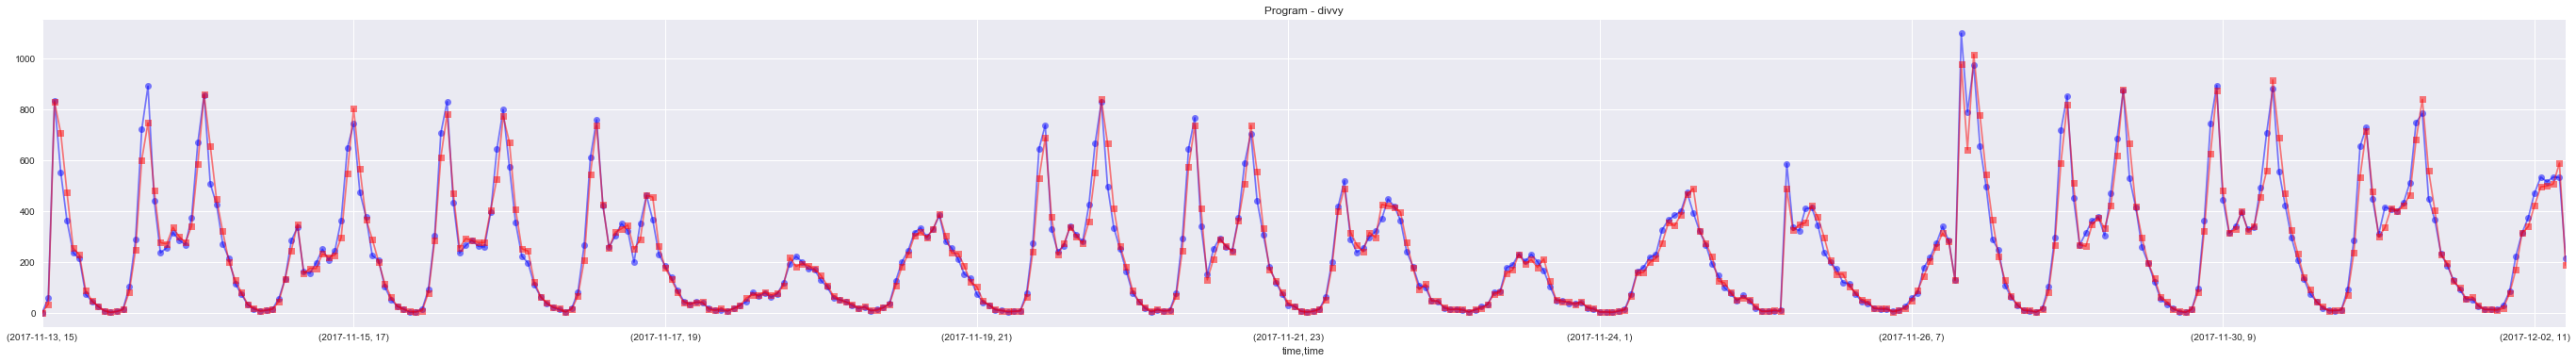

guad                     	95029.0		94993.0		36.0


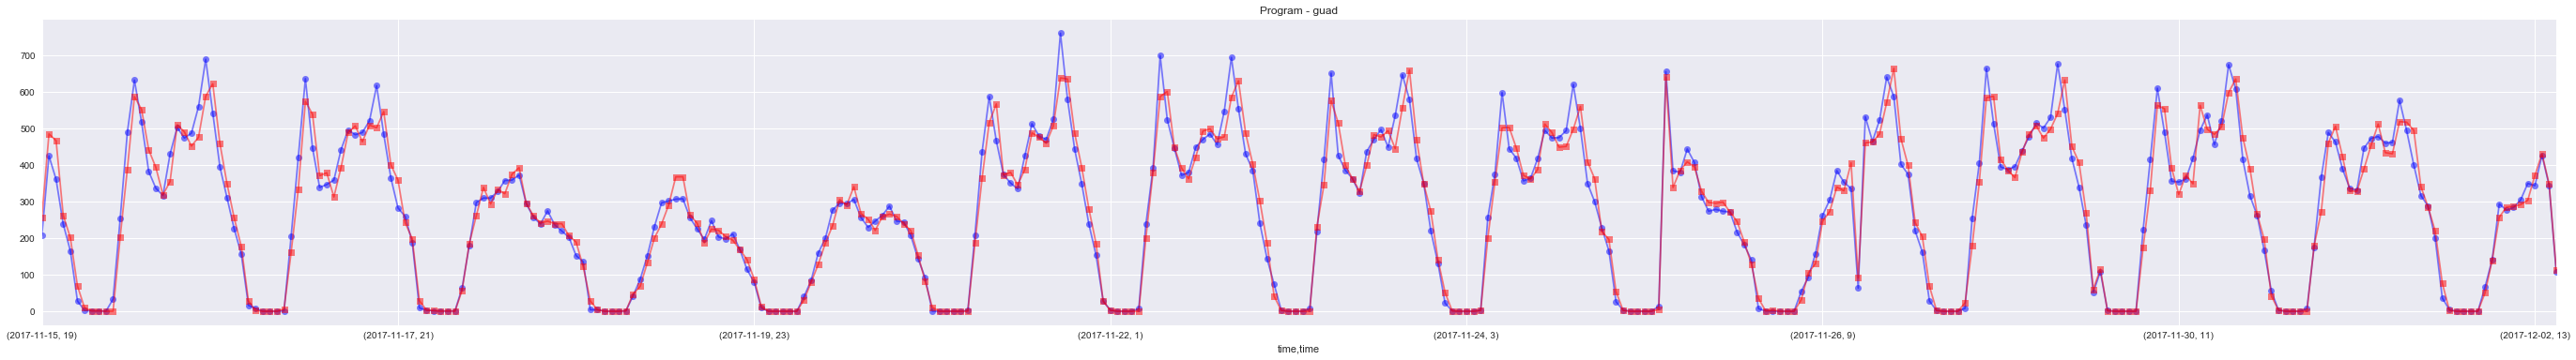

nyc                      	481258.0		479280.0		1978.0


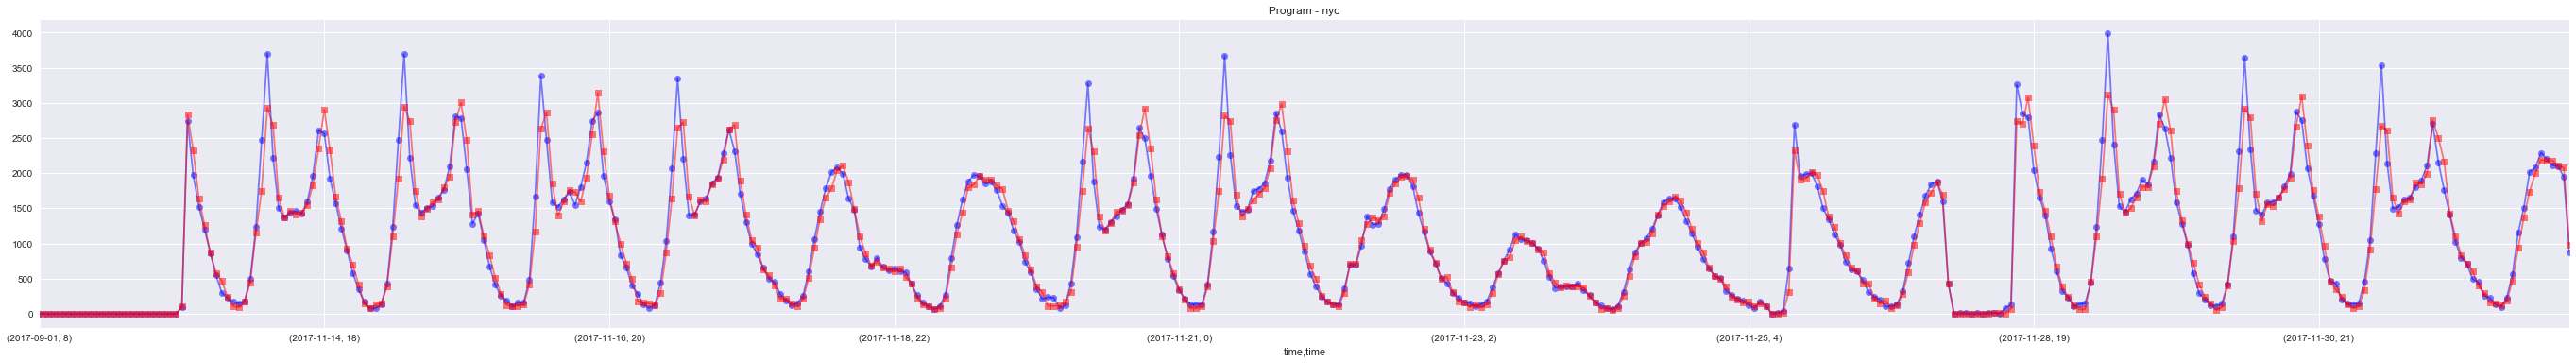

In [20]:
print('Program ID\t\t\tTrips Starting\tTrips Ending\tNet')
for pid in pd.unique(status_data.program_id):
    S = status_data[status_data.program_id == pid].trips_starting.sum()
    if S > 50000:
        E = status_data[status_data.program_id == pid].trips_ending.sum()
        print('%s\t%s\t\t%s\t\t%s' % (pid.ljust(25), str(S), str(E), S-E))
        fig, ax = plt.subplots(figsize=(48,6))
        data = status_data[status_data.program_id == pid].groupby([status_data.time.dt.date, status_data.time.dt.hour])
        data.trips_starting.sum().plot(kind ='line', color='b', alpha= 0.5, ax=ax, marker='o')
        data.trips_ending.sum().plot(kind ='line', color='r', alpha= 0.5, ax=ax, marker='s')
        title = 'Program - %s' % pid
        ax.set_title(title)
        plt.show()

Program ID			Trips Starting	Trips Ending	Net
ba                       	50717.0		50447.0		270.0


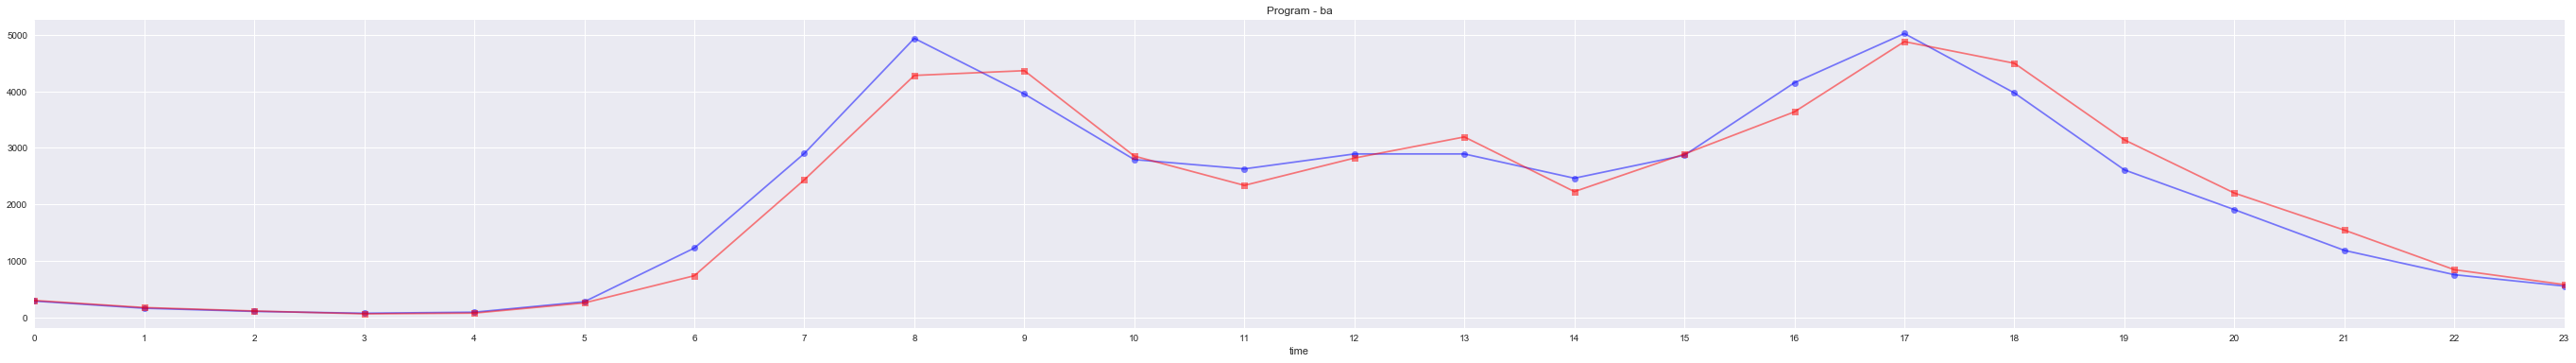

cabi                     	121246.0		121372.0		-126.0


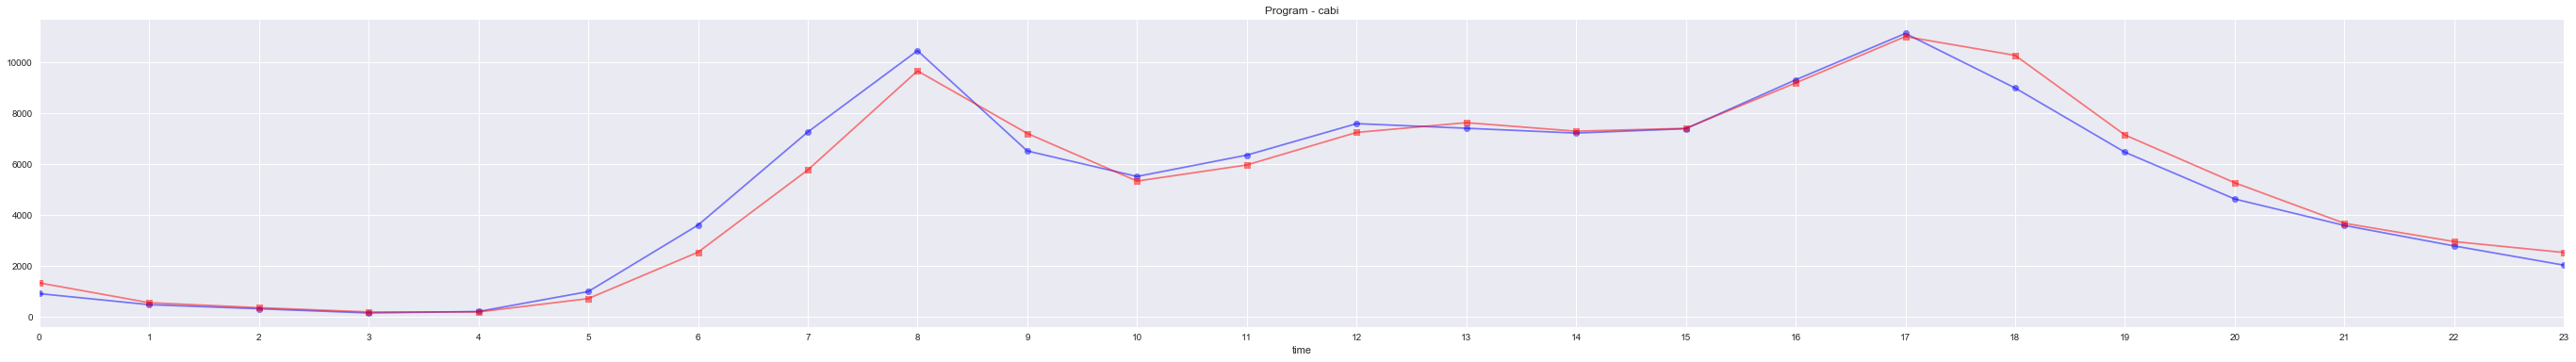

divvy                    	95272.0		94705.0		567.0


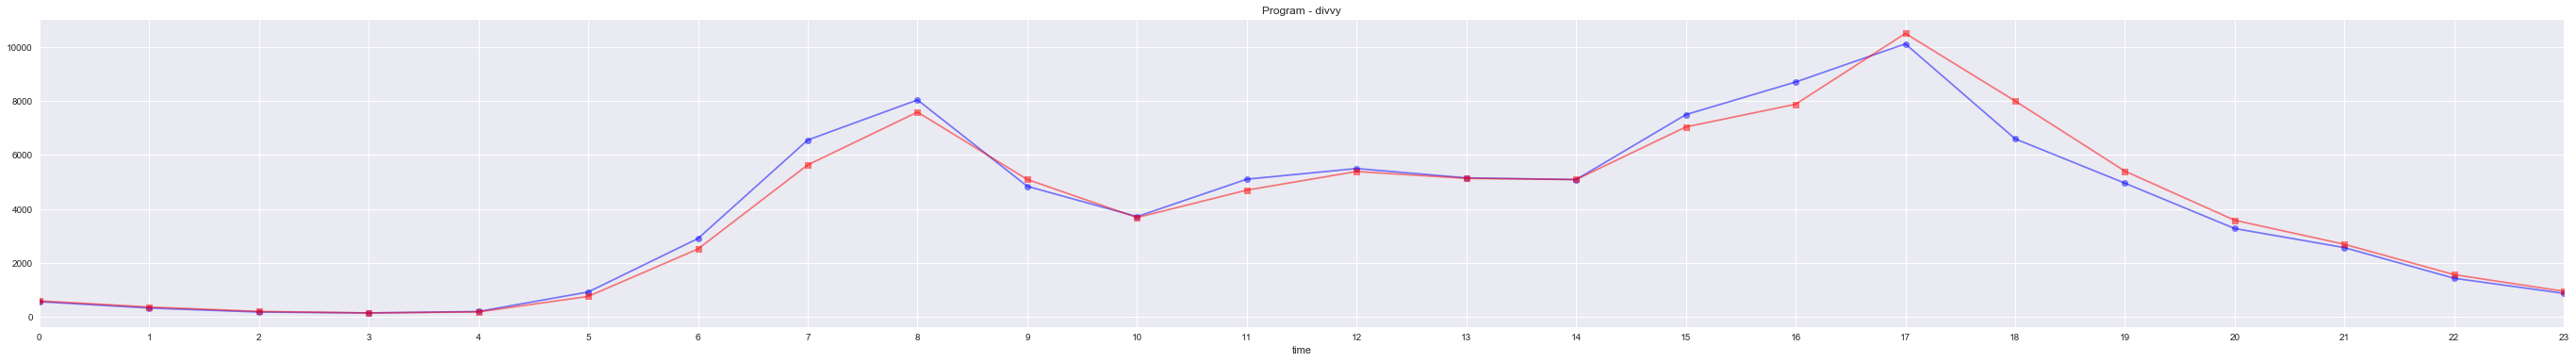

guad                     	95029.0		94993.0		36.0


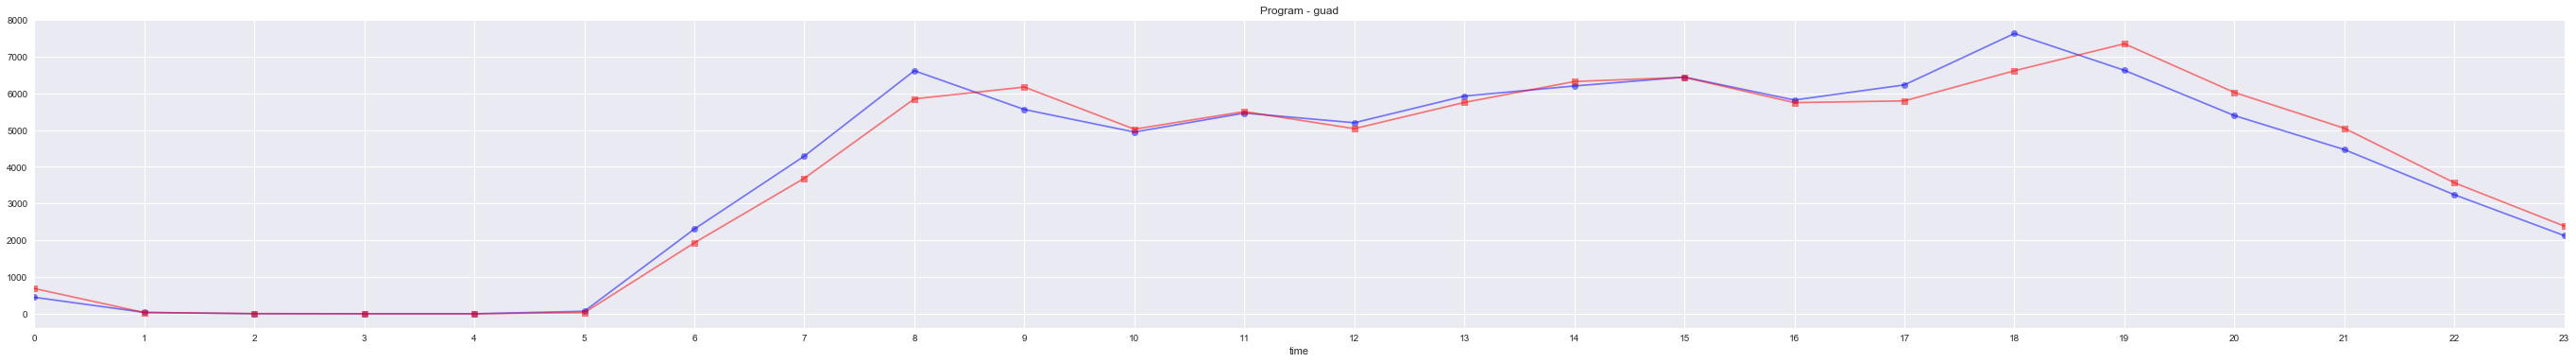

nyc                      	481258.0		479280.0		1978.0


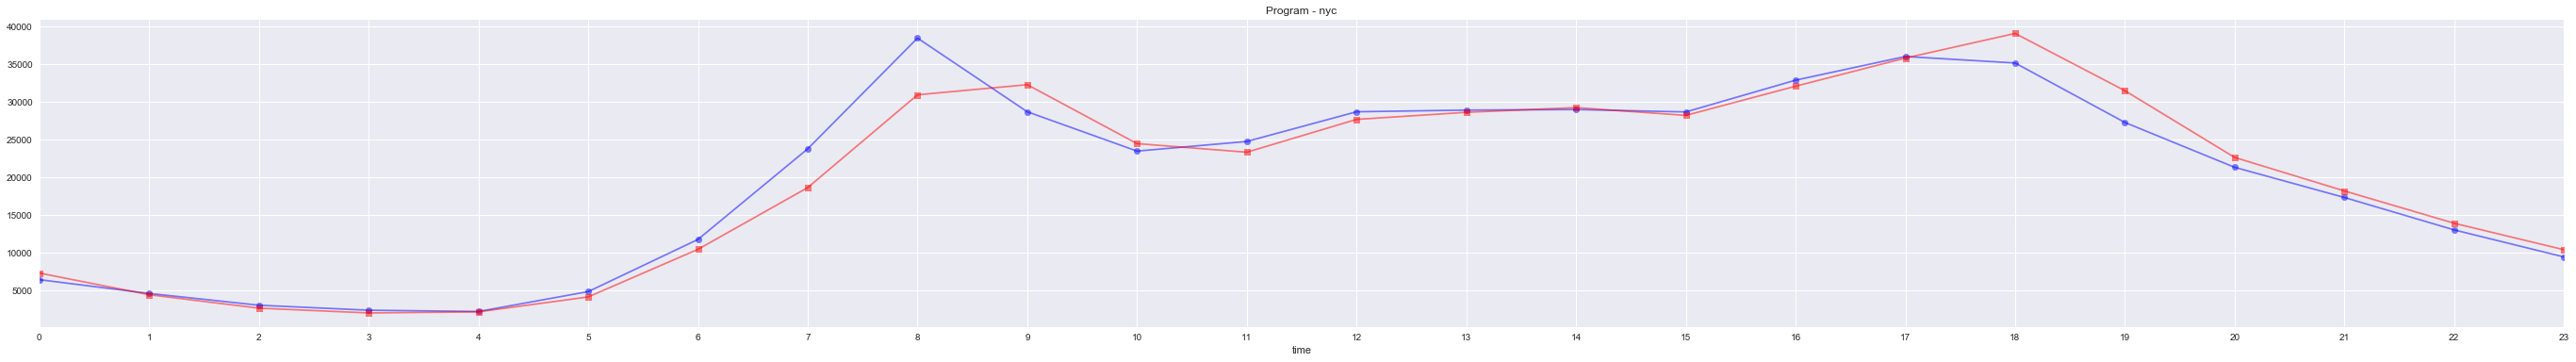

In [21]:
print('Program ID\t\t\tTrips Starting\tTrips Ending\tNet')
for pid in pd.unique(status_data.program_id):
    S = status_data[status_data.program_id == pid].trips_starting.sum()
    if S > 50000:
        E = status_data[status_data.program_id == pid].trips_ending.sum()
        print('%s\t%s\t\t%s\t\t%s' % (pid.ljust(25), str(S), str(E), S-E))
        fig, ax = plt.subplots(figsize=(48,6))
#         data = status_data_resample[status_data_resample.program_id == pid].groupby([status_data_resample.time.dt.dayofweek, status_data_resample.time.dt.hour])
        data = status_data[status_data.program_id == pid].groupby([status_data.time.dt.hour])
        data.trips_starting.sum().plot(kind ='line', color='b', alpha= 0.5, ax=ax, marker='o')
        data.trips_ending.sum().plot(kind ='line', color='r', alpha= 0.5, ax=ax, marker='s')
        title = 'Program - %s' % pid
        ax.set_title(title)
        x_ticks = range(0, 24)
        ax.set_xticks(x_ticks)
        plt.show()